In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import time
sys.path.append('../')

from util import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load the FICO dataset

In [2]:
DATA_DIR = '../data/'
file_name = ['transrisk_performance_by_race_ssa.csv','transrisk_cdf_by_race_ssa.csv','totals.csv']
df_repay = pd.read_csv(DATA_DIR + file_name[0])
df_cdf = pd.read_csv(DATA_DIR + file_name[1])
df_dm_ratio = pd.read_csv(DATA_DIR + file_name[2])

df_repay = df_repay.rename(columns={"Non- Hispanic white": "Caucasian", "Black": "African-American", "Hispanic":"Hispanic", "Asian":"Asian"})
df_cdf = df_cdf.rename(columns={"Non- Hispanic white": "Caucasian", "Black": "African-American", "Hispanic":"Hispanic", "Asian":"Asian"})
df_dm_ratio = df_dm_ratio.rename(columns={"Non- Hispanic white": "Caucasian", "Black": "African-American", "Hispanic":"Hispanic", "Asian":"Asian"})

df_cdf.iloc[:,1:] = df_cdf.iloc[:,1:]/100.0
df_repay.iloc[:,1:] = (100-df_repay.iloc[:,1:])/100.0

**Get probability density distributions from cumulative density function.**

In [3]:
nrow, ncol = df_cdf.shape
df_pdf = df_cdf.copy()
for i in range(nrow-1):
    indx = i + 1
    df_pdf.iloc[i+1,1:] = df_cdf.iloc[i+1,1:]- df_cdf.iloc[i,1:]

**The probability of repay given a score.**

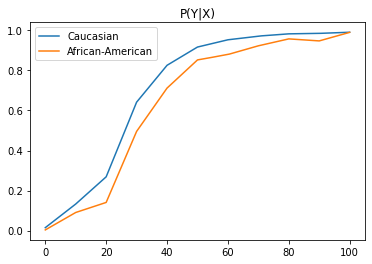

In [4]:

plt.plot(df_repay["Score"],df_repay.iloc[:,1],label='Caucasian')
plt.plot(df_repay["Score"],df_repay.iloc[:,2],label='African-American')
plt.title("P(Y|X)")
plt.legend()

**Score probability density functions.**

Text(0.5, 1.0, 'CDF of scores')

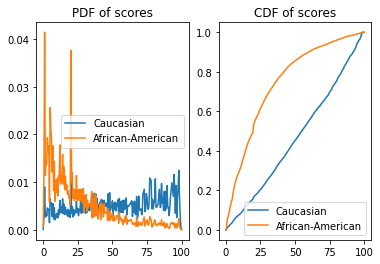

In [5]:
plt.subplot(1,2,1)
plt.plot(df_pdf["Score"],df_pdf['Caucasian'],label='Caucasian')
plt.plot(df_pdf["Score"],df_pdf['African-American'],label='African-American')
plt.title("PDF of scores")
plt.legend()
plt.subplot(1,2,2)
plt.plot(df_cdf["Score"],df_cdf['Caucasian'],label='Caucasian')
plt.plot(df_cdf["Score"],df_cdf['African-American'],label='African-American')
plt.legend()
plt.title("CDF of scores")

### Create a simulator 
**Step 1.** We first generate simulation data from the joint distributions which are given above, $P(X=x,Y=y \mid S= s) = P(Y=y \mid X=x, S= s)P(X=x\mid S=s)$.

In [6]:
np.random.seed(777)
# Step 1
NUM_SAMPLES = 100000
elements = df_pdf["Score"]
probabilities_c = df_pdf["Caucasian"]
probabilities_aa = df_pdf["African-American"]

scores_c = np.random.choice(elements, NUM_SAMPLES, p=probabilities_c)
scores_aa = np.random.choice(elements, NUM_SAMPLES, p=probabilities_aa)
prob_repay_c = [df_repay.loc[df_repay["Score"]==x]["Caucasian"].values[0] for x in scores_c]
prob_repay_aa = [df_repay.loc[df_repay["Score"]==x]["African-American"].values[0] for x in scores_aa]
repay_c = np.random.binomial(1, prob_repay_c, NUM_SAMPLES)
repay_aa = np.random.binomial(1, prob_repay_aa, NUM_SAMPLES)
scores_c = scores_c/100.0
scores_aa = scores_aa/100.0

**Step 2.** We estimate the generation distribution $P(X \mid Y=y, S=s)$ as beta distributions. 

In [7]:
from scipy.stats import beta
# Step 2
a_c1,b_c1,loc_c1,scale_c1 = beta.fit(scores_c[repay_c==1])
a_c0,b_c0,loc_c0,scale_c0 = beta.fit(scores_c[repay_c==0])
a_aa0,b_aa0,loc_aa0,scale_aa0 = beta.fit(scores_aa[repay_aa==0])
a_aa1,b_aa1,loc_aa1,scale_aa1 = beta.fit(scores_aa[repay_aa==1])


invalid value encountered in sqrt
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


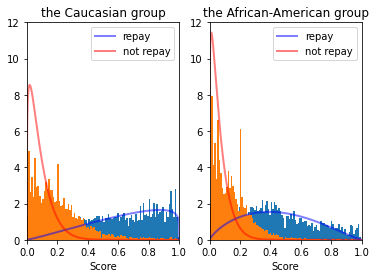

In [8]:
import scipy.stats as ss

def plot_beta(x_range, a, b, mu=0, sigma=1, cdf=False, **kwargs):
    '''
    Plots the f distribution function for a given x range, a and b
    If mu and sigma are not provided, standard beta is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.beta.cdf(x, a, b, mu, sigma)
    else:
        y = ss.beta.pdf(x, a, b, mu, sigma)
    plt.plot(x, y, **kwargs)

x = np.linspace(0, 1, 5000)
plt.subplot(1,2,1)
plt.ylim(0, 12)
plt.xlim(0, 1)
plot_beta(x, a_c1,b_c1, 0, 1, color='blue', lw=2, ls='-', alpha=0.5, label='repay')
plot_beta(x, a_c0,b_c0, 0, 1, color='red', lw=2, ls='-', alpha=0.5, label='not repay')
plt.hist(scores_c[repay_c==1], density=True, bins=100)
plt.hist(scores_c[repay_c==0], density=True, bins=100)
plt.title("the Caucasian group")
plt.xlabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.ylim(0, 12)
plt.xlim(0, 1)
plot_beta(x, a_aa1,b_aa1, 0, 1, color='blue', lw=2, ls='-', alpha=0.5, label='repay')
plot_beta(x,a_aa0,b_aa0, 0, 1, color='red', lw=2, ls='-', alpha=0.5, label='not repay')
plt.hist(scores_aa[repay_aa==1], density=True, bins=100)
plt.hist(scores_aa[repay_aa==0], density=True, bins=100)
plt.title("the African-American group")
plt.xlabel('Score')
plt.legend()

**A FICO Simulator.**  
The parameters for generation distributions are 
- a_c1,b_c1,loc_c1,scale_c1 
- a_c0,b_c0,loc_c0,scale_c0 
- a_aa0,b_aa0,loc_aa0,scale_aa0 
- a_aa1,b_aa1,loc_aa1,scale_aa1.  

In [9]:
df_c = pd.DataFrame(np.array([scores_c,repay_c,[1]*NUM_SAMPLES]).transpose(),
                   columns=['score', 'repay','group'])
df_aa = pd.DataFrame(np.array([scores_aa,repay_aa,[0]*NUM_SAMPLES]).transpose(),
                   columns=['score', 'repay','group'])

In [10]:
df_c.head()

,score,repay,group
0,0.195,0.0,1.0
1,0.355,1.0,1.0
2,0.075,1.0,1.0
3,0.510,0.0,1.0
4,0.865,1.0,1.0


In [11]:
df_aa.head()

,score,repay,group
0,0.050,0.0,0.0
1,0.055,0.0,0.0
2,0.270,1.0,0.0
3,0.110,0.0,0.0
4,0.200,0.0,0.0


In [14]:
P_C = df_dm_ratio.iloc[0]['Caucasian']/(df_dm_ratio.iloc[0]['Caucasian']+df_dm_ratio.iloc[0]['African-American'])
P_AA = 1 - P_C
P_AA,P_C

(0.12066904826365732, 0.8793309517363427)

In [15]:
alpha_aa_ini, alpha_c_ini = np.sum(repay_aa)/NUM_SAMPLES, np.sum(repay_c)/NUM_SAMPLES
alpha_aa_ini, alpha_c_ini 

(0.33624, 0.75785)

In [16]:
a_c0,b_c0,a_c1,b_c1,a_aa0,b_aa0,a_aa1,b_aa1,

(1.2225221837775146,
 13.267461665561074,
 2.1196726201192266,
 1.1624593741390017,
 1.1803726703516964,
 16.95711695756546,
 1.8113490035113031,
 2.2620132770838763)